In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install xgboost --upgrade

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)
sns.set_theme()

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, classification_report, make_scorer, recall_score, f1_score
from sklearn.model_selection import cross_val_score

In [ ]:
# fonction selectionnant les features et la target dans le dataframe
def Select_Column(df, features):
    return df[features]

# fonction dicotomisant les features de type object
def Object_dummies(df):
    return df.select_dtypes(exclude="object").join(
        pd.get_dummies(df.select_dtypes("object"))
    )

# fonction de séparation en jeu d'apprentissage (train) et jeu de test
def Train_Test(df, Goal):
  data = df.drop("Goal", 1)
  target = df["Goal"]
  X_train, X_test, y_train, y_test = train_test_split(
      data, target, test_size=0.2, random_state=78
      )
  return X_train, X_test, y_train, y_test

def NumPumpsAttending(df, pumps, max):
  liste = list(np.arange(pumps,max+1))
  return df['NumPumpsAttending'].replace(liste, pumps)

In [ ]:
from pickle import *

In [ ]:
# Fichier de base
df = pd.read_pickle(
    "/content/drive/MyDrive/Projet Pompier/Github/structure_finale/data_outputs/base_ml.pkl")

In [ ]:
df.head()

,IncidentNumber,Resource_Code,DateAndTimeMobilised,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,DeployedFromStation_Code,DeployedFromStation_Name,DeployedFromLocation,PumpOrder,DelayCode_Description,Appliance,PropertyCategory,PropertyType,AddressQualifier,IncidentStationGround,NumStationsWithPumpsAttending,NumPumpsAttending,Mobilised_Rank,IncidentType,IncidentCategory,FalseAlarm,Distance,TotalOfPumpInLondon_Out,PumpByStation,Station_Code_of_ressource,IncidentStationGround_Code,PumpOfIncidentStation_Out,PumpAvailable,year,month,day,weekday,hour,temp,precip,cloudcover,visibility,conditions,icon,workingday,school_holidays,congestion_rate
0,000412-01012018,F261,2018-01-01,74,191,265,F26,Bethnal Green,Home Station,1,No delay,Pump Dual Ladder,Outdoor,Park,Open land/water - nearest gazetteer location,Bethnal Green,1,1,1,Domestic Incidents,Effecting entry/exit,0,0.629,2,1,F26,F26,0,1,2018,1,1,Monday,18,7.0,0.3,0.2,29.0,Rain,rain,0,1.0,0.47
1,000413-01012018,G272,2018-01-01,85,109,194,G27,North Kensington,Home Station,1,No delay,Pump Ladder,Dwelling,Purpose Built Flats/Maisonettes - Up to 3 stor...,Correct incident location,North Kensington,1,1,1,Domestic Incidents,Effecting entry/exit,0,0.849,3,2,G27,G27,0,2,2018,1,1,Monday,18,7.0,0.3,0.2,29.0,Rain,rain,0,1.0,0.47
2,000415-01012018,G301,2018-01-01,72,167,239,G30,Wembley,Home Station,1,No delay,Pump Dual Ladder,Outdoor,Tree scrub,On land associated with building,Wembley,1,1,1,Fire,Secondary Fire,0,1.319,4,2,G30,G30,0,2,2018,1,1,Monday,18,7.0,0.3,0.2,29.0,Rain,rain,0,1.0,0.47
3,000417-01012018,G291,2018-01-01,123,364,487,G29,Park Royal,Home Station,1,Address incomplete/wrong,Pump Dual Ladder,Outdoor,Domestic garden (vegetation not equipment),On land associated with building,Wembley,2,2,1,Fire,False alarm - Good intent,1,1.296,3,2,G29,G30,1,1,2018,1,1,Monday,18,7.0,0.3,0.2,29.0,Rain,rain,0,1.0,0.47
4,000417-01012018,G281,2018-01-01,40,453,493,G28,Willesden,Home Station,2,Address incomplete/wrong,Pump Dual Ladder,Outdoor,Domestic garden (vegetation not equipment),On land associated with building,Wembley,2,2,1,Fire,False alarm - Good intent,1,2.728,4,2,G28,G30,1,1,2018,1,1,Monday,18,7.0,0.3,0.2,29.0,Rain,rain,0,1.0,0.47


In [ ]:
# Jeux de données entrainement et test : travaux préliminaire pour choix des numéros d'incidents

# paramètres généraux
tts_test_size = 0.2    # définir la proportion du nombre d'incidents à affecter au jeu de test
np.random.seed(42)     # fixer le caractère aléatoire (même base + même seed => donnera la même liste)

# Faire la liste des incidents et la trier
tts_inc_list = df['IncidentNumber'].unique().tolist()
tts_inc_list.sort()

# Total des véhicules et incidents pour juger de la répartition train / test
tts_nb_pump = df.shape[0]
tts_nb_inc = len(tts_inc_list)

# Taille de la liste des incidents à mettre en jeu de test
tts_test_size_nb = np.int64(tts_nb_inc * tts_test_size)

# liste des n° d'incidents à garder dans le jeu de test = sélectionner 'test_size_nb' éléments de la liste, par un tirage sans remise
tts_inc_test_list = list(np.random.choice(tts_inc_list, tts_test_size_nb, replace= False))



In [ ]:
# On conserve uniquement les camions envoyés lors de la première vague 
df=df[df['Mobilised_Rank']==1]
df.shape

(547865, 43)

In [ ]:
 # On ne conserve qu'une seule ligne par Incident
df = df.drop_duplicates(subset=['IncidentNumber'])
df.shape

(359880, 43)

Text(0, 0.5, "Nombre d'incidents")

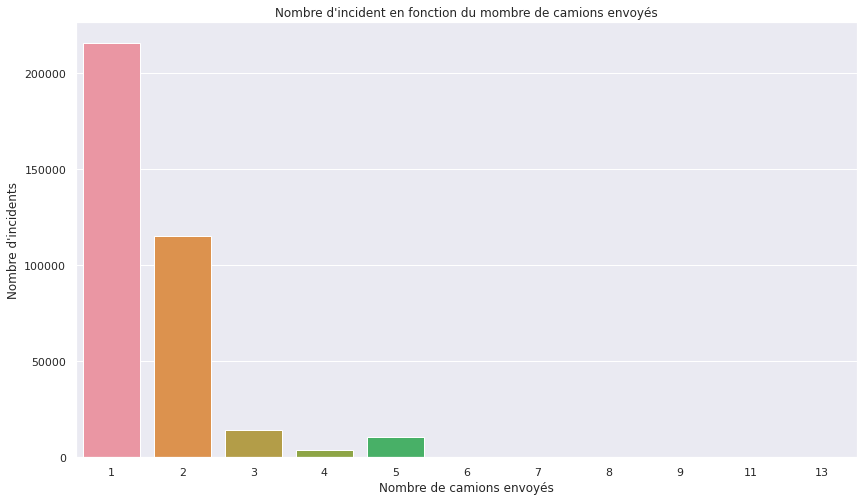

In [ ]:
# On affiche le nombre d'incident en fonciton du nombre de camions envoyés lors de la première vague 
plt.figure(figsize=(14,8))
sns.countplot(x = df['NumPumpsAttending'])
plt.title("Nombre d'incident en fonction du mombre de camions envoyés")
plt.xlabel('Nombre de camions envoyés')
plt.ylabel("Nombre d'incidents")

In [ ]:
# On supprimer les incidents des fausses alarmes
df=df[(df['IncidentCategory']!= "False alarm - Good intent") & 
      (df['IncidentCategory']!= "False alarm - Malicious") & 
      (df['IncidentCategory']!= "No action (not false alarm)")]

df.shape

(307330, 43)

In [ ]:
# sauvegarder les index des lignes des incidents que l'on affectera en test et train
# car nous allons ensuite supprimer la variable 'IncidentNumber'
tts_index_test = df[df['IncidentNumber'].isin(tts_inc_test_list)].index
tts_index_train = df[~df['IncidentNumber'].isin(tts_inc_test_list)].index

In [ ]:
df.columns

Index(['IncidentNumber', 'Resource_Code', 'DateAndTimeMobilised',
       'TurnoutTimeSeconds', 'TravelTimeSeconds', 'AttendanceTimeSeconds',
       'DeployedFromStation_Code', 'DeployedFromStation_Name',
       'DeployedFromLocation', 'PumpOrder', 'DelayCode_Description',
       'Appliance', 'PropertyCategory', 'PropertyType', 'AddressQualifier',
       'IncidentStationGround', 'NumStationsWithPumpsAttending',
       'NumPumpsAttending', 'Mobilised_Rank', 'IncidentType',
       'IncidentCategory', 'FalseAlarm', 'Distance', 'TotalOfPumpInLondon_Out',
       'PumpByStation', 'Station_Code_of_ressource',
       'IncidentStationGround_Code', 'PumpOfIncidentStation_Out',
       'PumpAvailable', 'year', 'month', 'day', 'weekday', 'hour', 'temp',
       'precip', 'cloudcover', 'visibility', 'conditions', 'icon',
       'workingday', 'school_holidays', 'congestion_rate'],
      dtype='object')

In [ ]:
# On selectionne les variables utilisées pour notre modèle
 
colonne_a_conserver = [#'IncidentNumber',
                       #'Resource_Code',
                       #'DateAndTimeMobilised',
                       #'TurnoutTimeSeconds',
                       #'TravelTimeSeconds',
                       #'AttendanceTimeSeconds',
                       #'DeployedFromStation_Code',
                       #'DeployedFromStation_Name',
                       #'DeployedFromLocation',
                       #'PumpOrder',
                       #'DelayCode_Description',
                       #'Appliance',
                       'PropertyCategory',
                       'PropertyType',
                       'AddressQualifier',
                       #'IncidentStationGround',
                       #'NumStationsWithPumpsAttending',
                       'NumPumpsAttending',
                       #'TimeOnIncidentSeconds',
                       #'TimeTotalSeconds',
                       #'Mobilised_Rank',
                       #'Outdoor Structure','Road Vehicle','Outdoor','Dwelling','Other Residential','Aircraft','Boat','Rail Vehicle','Non Residential',
                       'IncidentType',
                       'IncidentCategory',
                       #'FalseAlarm',
                       #'Distance',
                       #'TotalOfPumpInLondon_Out',
                       #'PumpByStation',
                       #'Station_Code_of_ressource',
                       #'IncidentStationGround_Code',
                       #'PumpOfIncidentStation_Out',
                       #'PumpAvailable',
                       #'year',
                       #'month',
                       #'day',
                       #'weekday',
                       #'hour',
                       #'temp',
                       #'precip',
                       #'cloudcover',
                       #'visibility',
                       #'conditions',
                       #'icon',
                       #'workingday',
                       #'school_holidays',
                       #'congestion_rate'
                       ]

In [ ]:
df = Select_Column(df, colonne_a_conserver)

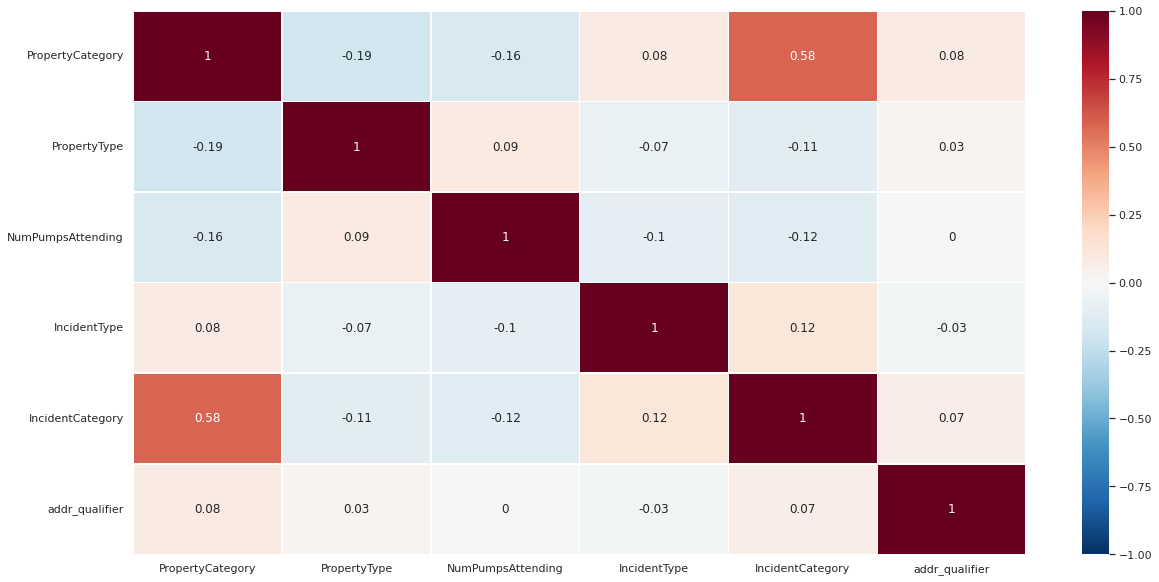

In [ ]:
# On visualise la corrélation entre les variables

plt.figure(figsize=(20,10))
sns.heatmap(np.round(df.assign(PropertyCategory = df.PropertyCategory.astype('category').cat.codes,
                                PropertyType = df.PropertyType.astype('category').cat.codes,
                                addr_qualifier = df.AddressQualifier.astype('category').cat.codes,
                                IncidentCategory = df.IncidentCategory.astype('category').cat.codes,
                               IncidentType = df.IncidentType.astype('category').cat.codes,
                               #IncidentStation = df.IncidentStationGround.astype('category').cat.codes,
                                #workingday = df.workingday.astype('category').cat.codes,
                                #school_holidays = df.school_holidays.astype('category').cat.codes,
                                #congestion_rate = df.congestion_rate.astype('category').cat.codes
                               ).corr(), 2),
            center = 0, cmap='RdBu_r', annot=True, vmin=-1, vmax=1, linewidths=0.5);

# AttendanceTimeSeconds est notre variable à prédire (temps de réponse)
# on remarque que peu la distance est LA variable explicative principale
# puis sur un second plan, vient la variable PumpAvailable, indiquant la disponibilité du matériel.

# Cette configuration reflète bien l'efficacité de la LFB, démontrant ainsi que la priorité est l'intervention rapide.

In [ ]:
df.columns

Index(['PropertyCategory', 'PropertyType', 'AddressQualifier',
       'NumPumpsAttending', 'IncidentType', 'IncidentCategory'],
      dtype='object')

In [ ]:
# On dichotomise nos variables catégorielles
colonne = ['PropertyCategory',
           'PropertyType',
           'AddressQualifier',
           #'NumPumpsAttending',
           'IncidentCategory',
           'IncidentType'
           #'workingday',
           #'school_holidays',
           #'congestion_rate'
           ]

df = pd.get_dummies(df, columns = colonne)
df.shape

(307330, 335)

In [ ]:
df.head()

,NumPumpsAttending,PropertyCategory_Aircraft,PropertyCategory_Boat,PropertyCategory_Dwelling,PropertyCategory_Non Residential,PropertyCategory_Other Residential,PropertyCategory_Outdoor,PropertyCategory_Outdoor Structure,PropertyCategory_Rail Vehicle,PropertyCategory_Road Vehicle,PropertyType_Agricultural equipment,PropertyType_Agricultural vehicle,PropertyType_Airfield/runway,PropertyType_Airport - fuel storage,PropertyType_Airport - hangar,PropertyType_Airport - terminal,PropertyType_Airport building (not terminal or hangar),PropertyType_Ambulance station,PropertyType_Animal boarding/breeding establishment - cats,PropertyType_Animal boarding/breeding establishment - dogs,PropertyType_Animal harm outdoors,PropertyType_Animal products processing plant,PropertyType_Art Gallery,PropertyType_Athletics Stadium,PropertyType_Bakery,PropertyType_Bank/Building Society,PropertyType_Barbecue,PropertyType_Barge,PropertyType_Barn,PropertyType_Beach,PropertyType_Bicycle,PropertyType_Bingo Hall,PropertyType_Boarding House/B&B for homeless/asylum seekers,PropertyType_Boarding House/B&B other,PropertyType_Boarding School accommodation,PropertyType_Bridge,PropertyType_Bulk gas storage,PropertyType_Bulk hazardous materials storage,PropertyType_Bulk oil storage,PropertyType_Bulk waste storage,PropertyType_Bungalow - single occupancy,PropertyType_Bus/coach,PropertyType_Bus/coach station/garage,PropertyType_Cables,PropertyType_Call Centre,PropertyType_Camping tent,PropertyType_Canal/riverbank vegetation,PropertyType_Car,PropertyType_Caravan on tow,PropertyType_Caravan/Mobile home (permanent dwelling),PropertyType_Casino,PropertyType_Castle (part not open to public),PropertyType_Cathedral,PropertyType_Cemetery,PropertyType_Central Government Office,PropertyType_Chemical plant,PropertyType_Children's Home,PropertyType_Church/Chapel,PropertyType_Cinema,PropertyType_Club/night club,PropertyType_College/University,PropertyType_Common external bin storage area,PropertyType_Community centre/Hall,PropertyType_Concert Hall,PropertyType_Conference Centre,PropertyType_Converted Flat/Maisonette - Up to 2 storeys,PropertyType_Converted Flat/Maisonettes - 3 or more storeys,PropertyType_Converted office,PropertyType_Cricket ground,PropertyType_Cycle path/public footpath/bridleway,PropertyType_DIY Warehouse,PropertyType_Day care/Drop in centre,PropertyType_Dental surgery,PropertyType_Department Store,PropertyType_Distillery plant,PropertyType_Docks,PropertyType_Doctors surgery,PropertyType_Domestic garden (vegetation not equipment),PropertyType_Electrical warehouse,PropertyType_Electricity power station,PropertyType_Engineering manufacturing plant,PropertyType_Estate Agent,PropertyType_Exhibition Centre,PropertyType_Factory,PropertyType_False Alarm - Property not found,PropertyType_Fence,PropertyType_Ferry terminal,PropertyType_Fire station,PropertyType_Fishing boat,PropertyType_Food and drink processing,PropertyType_Football stadium,PropertyType_Freight Train,PropertyType_Freight plane,PropertyType_Furniture warehouse,PropertyType_Garden equipment,PropertyType_Gas works,PropertyType_Golf clubhouse,PropertyType_Golf course (not building on course),PropertyType_Grassland/ pasture/ grazing etc,PropertyType_Greenhouse (commercial) glass,PropertyType_Greyhound stadium,PropertyType_Gym,PropertyType_Hairdresser,PropertyType_Health Centre,PropertyType_Health spa/farm,PropertyType_Heathland,PropertyType_Hedge,PropertyType_Helicopter,PropertyType_Hospital,PropertyType_Hostel (e.g. for homeless people),PropertyType_Hotel/motel,PropertyType_House - single occupancy,PropertyType_House in Multiple Occupation - 3 or more storeys (not known if licensed),PropertyType_House in Multiple Occupation - Up to 2 storeys (not known if licensed),PropertyType_Houseboat (permanent dwelling),PropertyType_Human harm outdoors,PropertyType_Ice rink,PropertyType_Indoor Market,PropertyType_Indoor stadium,PropertyType_Infant/Primary school,PropertyType_Intensive Farming Sheds (chickens/ pigs etc)

In [ ]:
# On limite la variable "NumPumpsAttenging" à 5 classes en considérant tous les incidents à 5 camions et plus par 5.
df['NumPumpsAttending'] = NumPumpsAttending(df, 5, 15)

df['NumPumpsAttending'].value_counts()

1    189245
2     94503
3     11765
5      8598
4      3219
Name: NumPumpsAttending, dtype: int64

In [ ]:
df.head()

,NumPumpsAttending,PropertyCategory_Aircraft,PropertyCategory_Boat,PropertyCategory_Dwelling,PropertyCategory_Non Residential,PropertyCategory_Other Residential,PropertyCategory_Outdoor,PropertyCategory_Outdoor Structure,PropertyCategory_Rail Vehicle,PropertyCategory_Road Vehicle,PropertyType_Agricultural equipment,PropertyType_Agricultural vehicle,PropertyType_Airfield/runway,PropertyType_Airport - fuel storage,PropertyType_Airport - hangar,PropertyType_Airport - terminal,PropertyType_Airport building (not terminal or hangar),PropertyType_Ambulance station,PropertyType_Animal boarding/breeding establishment - cats,PropertyType_Animal boarding/breeding establishment - dogs,PropertyType_Animal harm outdoors,PropertyType_Animal products processing plant,PropertyType_Art Gallery,PropertyType_Athletics Stadium,PropertyType_Bakery,PropertyType_Bank/Building Society,PropertyType_Barbecue,PropertyType_Barge,PropertyType_Barn,PropertyType_Beach,PropertyType_Bicycle,PropertyType_Bingo Hall,PropertyType_Boarding House/B&B for homeless/asylum seekers,PropertyType_Boarding House/B&B other,PropertyType_Boarding School accommodation,PropertyType_Bridge,PropertyType_Bulk gas storage,PropertyType_Bulk hazardous materials storage,PropertyType_Bulk oil storage,PropertyType_Bulk waste storage,PropertyType_Bungalow - single occupancy,PropertyType_Bus/coach,PropertyType_Bus/coach station/garage,PropertyType_Cables,PropertyType_Call Centre,PropertyType_Camping tent,PropertyType_Canal/riverbank vegetation,PropertyType_Car,PropertyType_Caravan on tow,PropertyType_Caravan/Mobile home (permanent dwelling),PropertyType_Casino,PropertyType_Castle (part not open to public),PropertyType_Cathedral,PropertyType_Cemetery,PropertyType_Central Government Office,PropertyType_Chemical plant,PropertyType_Children's Home,PropertyType_Church/Chapel,PropertyType_Cinema,PropertyType_Club/night club,PropertyType_College/University,PropertyType_Common external bin storage area,PropertyType_Community centre/Hall,PropertyType_Concert Hall,PropertyType_Conference Centre,PropertyType_Converted Flat/Maisonette - Up to 2 storeys,PropertyType_Converted Flat/Maisonettes - 3 or more storeys,PropertyType_Converted office,PropertyType_Cricket ground,PropertyType_Cycle path/public footpath/bridleway,PropertyType_DIY Warehouse,PropertyType_Day care/Drop in centre,PropertyType_Dental surgery,PropertyType_Department Store,PropertyType_Distillery plant,PropertyType_Docks,PropertyType_Doctors surgery,PropertyType_Domestic garden (vegetation not equipment),PropertyType_Electrical warehouse,PropertyType_Electricity power station,PropertyType_Engineering manufacturing plant,PropertyType_Estate Agent,PropertyType_Exhibition Centre,PropertyType_Factory,PropertyType_False Alarm - Property not found,PropertyType_Fence,PropertyType_Ferry terminal,PropertyType_Fire station,PropertyType_Fishing boat,PropertyType_Food and drink processing,PropertyType_Football stadium,PropertyType_Freight Train,PropertyType_Freight plane,PropertyType_Furniture warehouse,PropertyType_Garden equipment,PropertyType_Gas works,PropertyType_Golf clubhouse,PropertyType_Golf course (not building on course),PropertyType_Grassland/ pasture/ grazing etc,PropertyType_Greenhouse (commercial) glass,PropertyType_Greyhound stadium,PropertyType_Gym,PropertyType_Hairdresser,PropertyType_Health Centre,PropertyType_Health spa/farm,PropertyType_Heathland,PropertyType_Hedge,PropertyType_Helicopter,PropertyType_Hospital,PropertyType_Hostel (e.g. for homeless people),PropertyType_Hotel/motel,PropertyType_House - single occupancy,PropertyType_House in Multiple Occupation - 3 or more storeys (not known if licensed),PropertyType_House in Multiple Occupation - Up to 2 storeys (not known if licensed),PropertyType_Houseboat (permanent dwelling),PropertyType_Human harm outdoors,PropertyType_Ice rink,PropertyType_Indoor Market,PropertyType_Indoor stadium,PropertyType_Infant/Primary school,PropertyType_Intensive Farming Sheds (chickens/ pigs etc)

In [ ]:
df.describe()

,NumPumpsAttending,PropertyCategory_Aircraft,PropertyCategory_Boat,PropertyCategory_Dwelling,PropertyCategory_Non Residential,PropertyCategory_Other Residential,PropertyCategory_Outdoor,PropertyCategory_Outdoor Structure,PropertyCategory_Rail Vehicle,PropertyCategory_Road Vehicle,PropertyType_Agricultural equipment,PropertyType_Agricultural vehicle,PropertyType_Airfield/runway,PropertyType_Airport - fuel storage,PropertyType_Airport - hangar,PropertyType_Airport - terminal,PropertyType_Airport building (not terminal or hangar),PropertyType_Ambulance station,PropertyType_Animal boarding/breeding establishment - cats,PropertyType_Animal boarding/breeding establishment - dogs,PropertyType_Animal harm outdoors,PropertyType_Animal products processing plant,PropertyType_Art Gallery,PropertyType_Athletics Stadium,PropertyType_Bakery,PropertyType_Bank/Building Society,PropertyType_Barbecue,PropertyType_Barge,PropertyType_Barn,PropertyType_Beach,PropertyType_Bicycle,PropertyType_Bingo Hall,PropertyType_Boarding House/B&B for homeless/asylum seekers,PropertyType_Boarding House/B&B other,PropertyType_Boarding School accommodation,PropertyType_Bridge,PropertyType_Bulk gas storage,PropertyType_Bulk hazardous materials storage,PropertyType_Bulk oil storage,PropertyType_Bulk waste storage,PropertyType_Bungalow - single occupancy,PropertyType_Bus/coach,PropertyType_Bus/coach station/garage,PropertyType_Cables,PropertyType_Call Centre,PropertyType_Camping tent,PropertyType_Canal/riverbank vegetation,PropertyType_Car,PropertyType_Caravan on tow,PropertyType_Caravan/Mobile home (permanent dwelling),PropertyType_Casino,PropertyType_Castle (part not open to public),PropertyType_Cathedral,PropertyType_Cemetery,PropertyType_Central Government Office,PropertyType_Chemical plant,PropertyType_Children's Home,PropertyType_Church/Chapel,PropertyType_Cinema,PropertyType_Club/night club,PropertyType_College/University,PropertyType_Common external bin storage area,PropertyType_Community centre/Hall,PropertyType_Concert Hall,PropertyType_Conference Centre,PropertyType_Converted Flat/Maisonette - Up to 2 storeys,PropertyType_Converted Flat/Maisonettes - 3 or more storeys,PropertyType_Converted office,PropertyType_Cricket ground,PropertyType_Cycle path/public footpath/bridleway,PropertyType_DIY Warehouse,PropertyType_Day care/Drop in centre,PropertyType_Dental surgery,PropertyType_Department Store,PropertyType_Distillery plant,PropertyType_Docks,PropertyType_Doctors surgery,PropertyType_Domestic garden (vegetation not equipment),PropertyType_Electrical warehouse,PropertyType_Electricity power station,PropertyType_Engineering manufacturing plant,PropertyType_Estate Agent,PropertyType_Exhibition Centre,PropertyType_Factory,PropertyType_False Alarm - Property not found,PropertyType_Fence,PropertyType_Ferry terminal,PropertyType_Fire station,PropertyType_Fishing boat,PropertyType_Food and drink processing,PropertyType_Football stadium,PropertyType_Freight Train,PropertyType_Freight plane,PropertyType_Furniture warehouse,PropertyType_Garden equipment,PropertyType_Gas works,PropertyType_Golf clubhouse,PropertyType_Golf course (not building on course),PropertyType_Grassland/ pasture/ grazing etc,PropertyType_Greenhouse (commercial) glass,PropertyType_Greyhound stadium,PropertyType_Gym,PropertyType_Hairdresser,PropertyType_Health Centre,PropertyType_Health spa/farm,PropertyType_Heathland,PropertyType_Hedge,PropertyType_Helicopter,PropertyType_Hospital,PropertyType_Hostel (e.g. for homeless people),PropertyType_Hotel/motel,PropertyType_House - single occupancy,PropertyType_House in Multiple Occupation - 3 or more storeys (not known if licensed),PropertyType_House in Multiple Occupation - Up to 2 storeys (not known if licensed),PropertyType_Houseboat (permanent dwelling),PropertyType_Human harm outdoors,PropertyType_Ice rink,PropertyType_Indoor Market,PropertyType_Indoor stadium,PropertyType_Infant/Primary school,PropertyType_Intensive Farming Sheds (chickens/ pigs etc)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307330 entries, 0 to 547863
Columns: 335 entries, NumPumpsAttending to IncidentType_Use of Special Operations Room
dtypes: int64(1), uint8(334)
memory usage: 102.6 MB


In [ ]:
df = df.astype(float)

In [ ]:
# On définit notre target "NumPumpsAttending" et nos data
data = df.drop(['NumPumpsAttending'], axis = 1)
target = df['NumPumpsAttending']

In [ ]:
# Jeux de données entrainement et test : création des jeux de données
# Création X_train, X_test, y_train, y_test
X_train = data.loc[tts_index_train]
X_test = data.loc[tts_index_test]
y_train = target.loc[tts_index_train]
y_test = target.loc[tts_index_test]

# Dimensions des jeux pour contrôle
print('Jeux de données créés :')
print('Dimensions (X_train, y_train) :', (X_train.shape, y_train.shape))
print('Dimensions (X_test, y_test)   :', (X_test.shape, y_test.shape))

# Statistiques 
print('Le jeu de données test représente', str(X_test.shape[0]/(X_test.shape[0]+X_train.shape[0])*100), '% des incidents')

Jeux de données créés :
Dimensions (X_train, y_train) : ((245973, 334), (245973,))
Dimensions (X_test, y_test)   : ((61357, 334), (61357,))
Le jeu de données test représente 19.964533237887615 % des incidents


Etude PCA

<Figure size 1008x576 with 0 Axes>

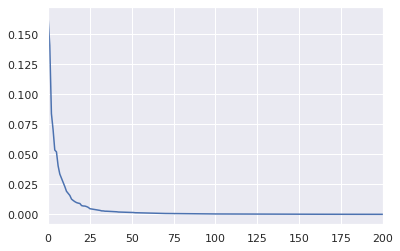

<Figure size 1008x576 with 0 Axes>

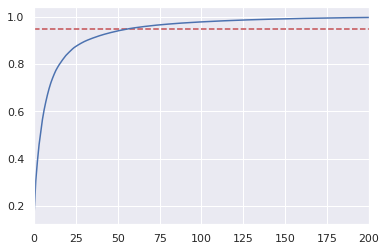

In [ ]:
# On effectue une analyse rapide avec la fonction PCA sur la variance des variables
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(data)

plt.figure(figsize=(14,8))
plt.figure()
plt.xlim(0,200)
plt.plot(pca.explained_variance_ratio_);

plt.figure(figsize=(14,8))
plt.figure()
plt.xlim(0,200)
plt.axhline(y = 0.95, color ='r', linestyle = '--')
plt.plot(pca.explained_variance_ratio_.cumsum());

In [ ]:
pca = PCA(n_components = 0.95)
pca.fit(data)
print("Nombre de composantes retenues pour une variance à 95%:", pca.n_components_)

pca = PCA(n_components = 0.99)
pca.fit(data)
print("Nombre de composantes retenues pour une variance à 99%:", pca.n_components_)

Nombre de composantes retenues pour une variance à 95%: 59
Nombre de composantes retenues pour une variance à 99%: 144


**Importance des variables avec un modèle de Regression Logistic**

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/yellowbrick/model_selection/importances.py:199: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


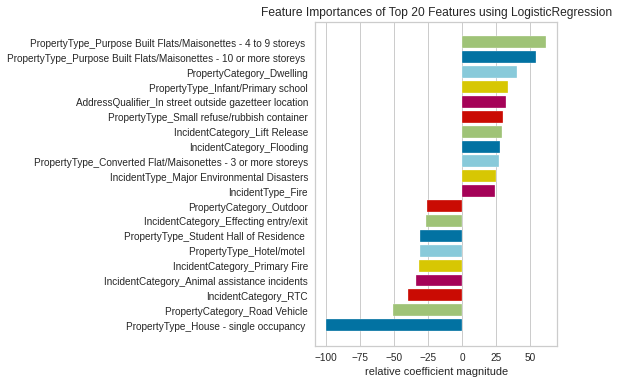

In [ ]:
# On effectue une première approche et on affiche l'importance des variables avec un modèle de Regression Logistic
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from yellowbrick.features import FeatureImportances

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

##viz = FeatureImportances(GradientBoostingClassifier(), ax=ax, topn=20)
viz = FeatureImportances(LogisticRegression(), ax=ax, topn=20)
viz.fit(data, target)
viz.poof()

# **Algorithme de Machine Learning**




XGBoost Classifier

In [ ]:
from xgboost import XGBClassifier

In [ ]:
# On lance le modèle choisi, XGB Classifier

from xgboost.sklearn import XGBModel
import xgboost as xgb
from xgboost import XGBClassifier
params= {'n_estimators': 170, 
         'max_depth': 20, 
         'reg_alpha': 3, 
         'reg_lambda': 2, 
         'min_child_weight': 5, 
         'gamma': 2, 
         'learning_rate': 0.1394833858118124, 
         'colsample_bytree': 0.47}

xgb = XGBClassifier(params=params)
xgb.fit(X_train, y_train)
print("score train xgb:",xgb.score(X_train, y_train))
print("score test xgb:",xgb.score(X_test, y_test))

score train xgb: 0.809088802429535
score test xgb: 0.8089215574425086


In [ ]:
scores = cross_val_score(xgb, X_train, y_train, cv=3)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.81 accuracy with a standard deviation of 0.01


In [ ]:
# On affiche la matrice de confusion
y_pred_xgb= xgb.predict(X_test)
pd.crosstab(y_test, y_pred_xgb, rownames=['Realité'], colnames=['Prédiction'])

Prédiction,1.0,2.0,3.0,5.0
Realité,,,,
1.0,34563,3254,4,73
2.0,4173,14456,7,105
3.0,449,1802,42,62
4.0,73,414,8,113
5.0,146,1041,0,572


In [ ]:
# On affiche le rapport de classification
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

         1.0       0.88      0.91      0.89     37894
         2.0       0.69      0.77      0.73     18741
         3.0       0.69      0.02      0.03      2355
         4.0       0.00      0.00      0.00       608
         5.0       0.62      0.33      0.43      1759

    accuracy                           0.81     61357
   macro avg       0.57      0.41      0.42     61357
weighted avg       0.80      0.81      0.79     61357



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 1440x576 with 0 Axes>

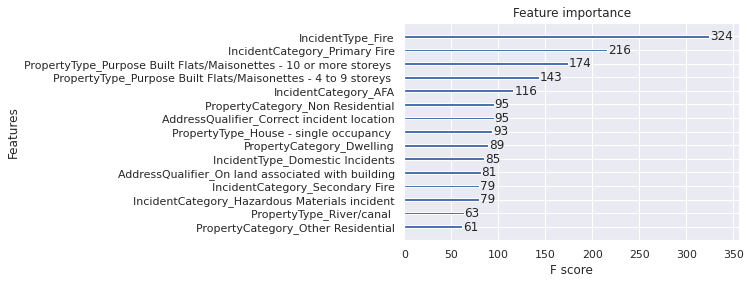

In [ ]:
# On affiche les variables importantes utilisées par le modèle XGBooost
from xgboost import plot_importance
from matplotlib import pyplot

# plot feature importance
plt.figure(figsize=(20,8))
plot_importance(xgb, max_num_features = 15)
pyplot.show()


In [ ]:
from joblib import dump
dump(xgb,'/content/drive/MyDrive/Projet Pompier/Github/structure_finale/data_outputs/ml_nb_pumps/Number_of_Pumps_XGB.joblib')